In [1]:
# === Step 1: Install Libraries (Run only once per session) ===
print("Installing libraries...")
# Force Pillow to be version 9.4.0 (known to be compatible)
!pip install Pillow==9.4.0 --force-reinstall -q 
!pip install "git+https://github.com/facebookresearch/detectron2.git" -q
!pip install layoutparser[layoutmodels] -q
!pip install "numpy<1.26.4" --force-reinstall -q
print("Library installation complete.")

# === Step 2: Download Model Files (Run only once per session) ===
import os
import requests 

config_url = "https://huggingface.co/nlpconnect/PubLayNet-faster_rcnn_R_50_FPN_3x/resolve/main/config.yml"
weights_url = "https://huggingface.co/nlpconnect/PubLayNet-faster_rcnn_R_50_FPN_3x/resolve/main/model_final.pth"
config_path = "config.yml"
weights_path = "model_final.pth"

def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() 
            with open(filename, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded {filename} successfully.")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {filename}: {e}")
            return False
    else:
        print(f"{filename} already exists.")
    return os.path.exists(filename)

model_files_ready = download_file(config_url, config_path) and download_file(weights_url, weights_path)

if not model_files_ready:
    print("Model download failed. Cannot proceed.")
else:
    print("Model files ready.")

    # === Step 3: Import Libraries ===
    import layoutparser as lp
    import cv2
    import numpy as np
    import os
    import math
    import json
    import glob
    from tqdm.notebook import tqdm 
    import shutil # Needed for zipping

    # === Step 4: Define Deskew Function (Hough Transform) ===
    # (Same deskew_image_hough function as before)
    def deskew_image_hough(image_bgr):
        gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        lines = cv2.HoughLinesP(thresh, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=10)

        if lines is None or len(lines) == 0:
            edges = cv2.Canny(gray, 50, 150, apertureSize=3)
            lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=50, maxLineGap=10)
            if lines is None or len(lines) == 0:
                return image_bgr, 0.0

        angles = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if x2 - x1 != 0:
                angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
                if -45 < angle < 45:
                     angles.append(angle)

        if not angles:
             return image_bgr, 0.0

        median_angle = np.median(angles)
        if abs(median_angle) < 0.5:
             return image_bgr, 0.0

        (h, w) = image_bgr.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
        rotated_bgr = cv2.warpAffine(image_bgr, M, (w, h),
                                    flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        return rotated_bgr, median_angle

    # === Step 5: Setup Paths, Mappings, and Model ===

    # --- Input Directory (Adjust as needed) ---
    IMAGE_DIR = "/kaggle/input/traindata/train/" 
    #-------------------------------------------

    # --- Output Directories ---
    OUTPUT_JSON_DIR = "/kaggle/working/trainjson/"
    OUTPUT_ZIP_FILE = "/kaggle/working/trainjson_submissions.zip" # Name of the zip file to create
    #--------------------------

    os.makedirs(OUTPUT_JSON_DIR, exist_ok=True) 

    # --- Category Mapping ---
    LABEL_TO_SUBMISSION_ID = { "Text": 1, "Title": 2, "List": 1, "Table": 5, "Figure": 5 }
    model_label_map = { 0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure" }
    #------------------------

    # --- Load Model ---
    try:
        model = lp.Detectron2LayoutModel(
            config_path=config_path,
            model_path=weights_path,
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7], 
            label_map=model_label_map 
        )
        print("Layout model loaded successfully.")
    except Exception as e:
        print(f"Error loading layout model: {e}")
        model = None 

    # === Step 6: Process Images and Generate JSONs ===
    if model: 
        image_paths = glob.glob(os.path.join(IMAGE_DIR, "*.[jp][pn]g"))
        print(f"Found {len(image_paths)} images to process.")

        # --- (Your image processing loop remains exactly the same as before) ---
        for image_path in tqdm(image_paths, desc="Generating Submission JSONs"):
            base_filename = os.path.basename(image_path)
            filename_no_ext = os.path.splitext(base_filename)[0]

            image_bgr = cv2.imread(image_path)
            if image_bgr is None: continue
            deskewed_bgr, angle = deskew_image_hough(image_bgr)
            image_to_process_rgb = cv2.cvtColor(deskewed_bgr, cv2.COLOR_BGR2RGB)

            try: layout = model.detect(image_to_process_rgb)
            except Exception as e: continue

            submission_annotations = []
            for element in layout:
                original_label = element.type 
                submission_cat_id = LABEL_TO_SUBMISSION_ID.get(original_label)
                if submission_cat_id is not None:
                    x1, y1, x2, y2 = map(int, element.coordinates)
                    submission_bbox = [x1, y1, x2 - x1, y2 - y1]
                    submission_annotations.append({"bbox": submission_bbox, "category_id": submission_cat_id})

            output_json_data = {"file_name": base_filename, "annotations": submission_annotations}
            output_json_filepath = os.path.join(OUTPUT_JSON_DIR, f"{filename_no_ext}.json")
            try:
                with open(output_json_filepath, 'w') as f: json.dump(output_json_data, f) 
            except Exception as e: print(f"Error writing JSON for {base_filename}: {e}")
        # --- (End of image processing loop) ---
        
        print(f"\nProcessing complete. Submission JSONs generated in: {OUTPUT_JSON_DIR}")

        # === Step 7: Zip the Output Folder ===
        print(f"Zipping the output folder '{os.path.basename(OUTPUT_JSON_DIR)}'...")
        try:
            shutil.make_archive(OUTPUT_ZIP_FILE.replace('.zip', ''), # Base name for zip
                                'zip',                             # Format
                                OUTPUT_JSON_DIR)                   # Directory to zip
            print(f"Successfully created zip file: {OUTPUT_ZIP_FILE}")
            print(f"\n---> You can now download '{os.path.basename(OUTPUT_ZIP_FILE)}' from the Kaggle 'Output' section on the right panel.")
        except Exception as e:
            print(f"Error creating zip file: {e}")

    else:
        print("Cannot proceed without a loaded model.")

Installing libraries...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.4.0 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is in

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Layout model loaded successfully.
Found 4000 images to process.


Generating Submission JSONs:   0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



Processing complete. Submission JSONs generated in: /kaggle/working/trainjson/
Zipping the output folder ''...
Successfully created zip file: /kaggle/working/trainjson_submissions.zip

---> You can now download 'trainjson_submissions.zip' from the Kaggle 'Output' section on the right panel.


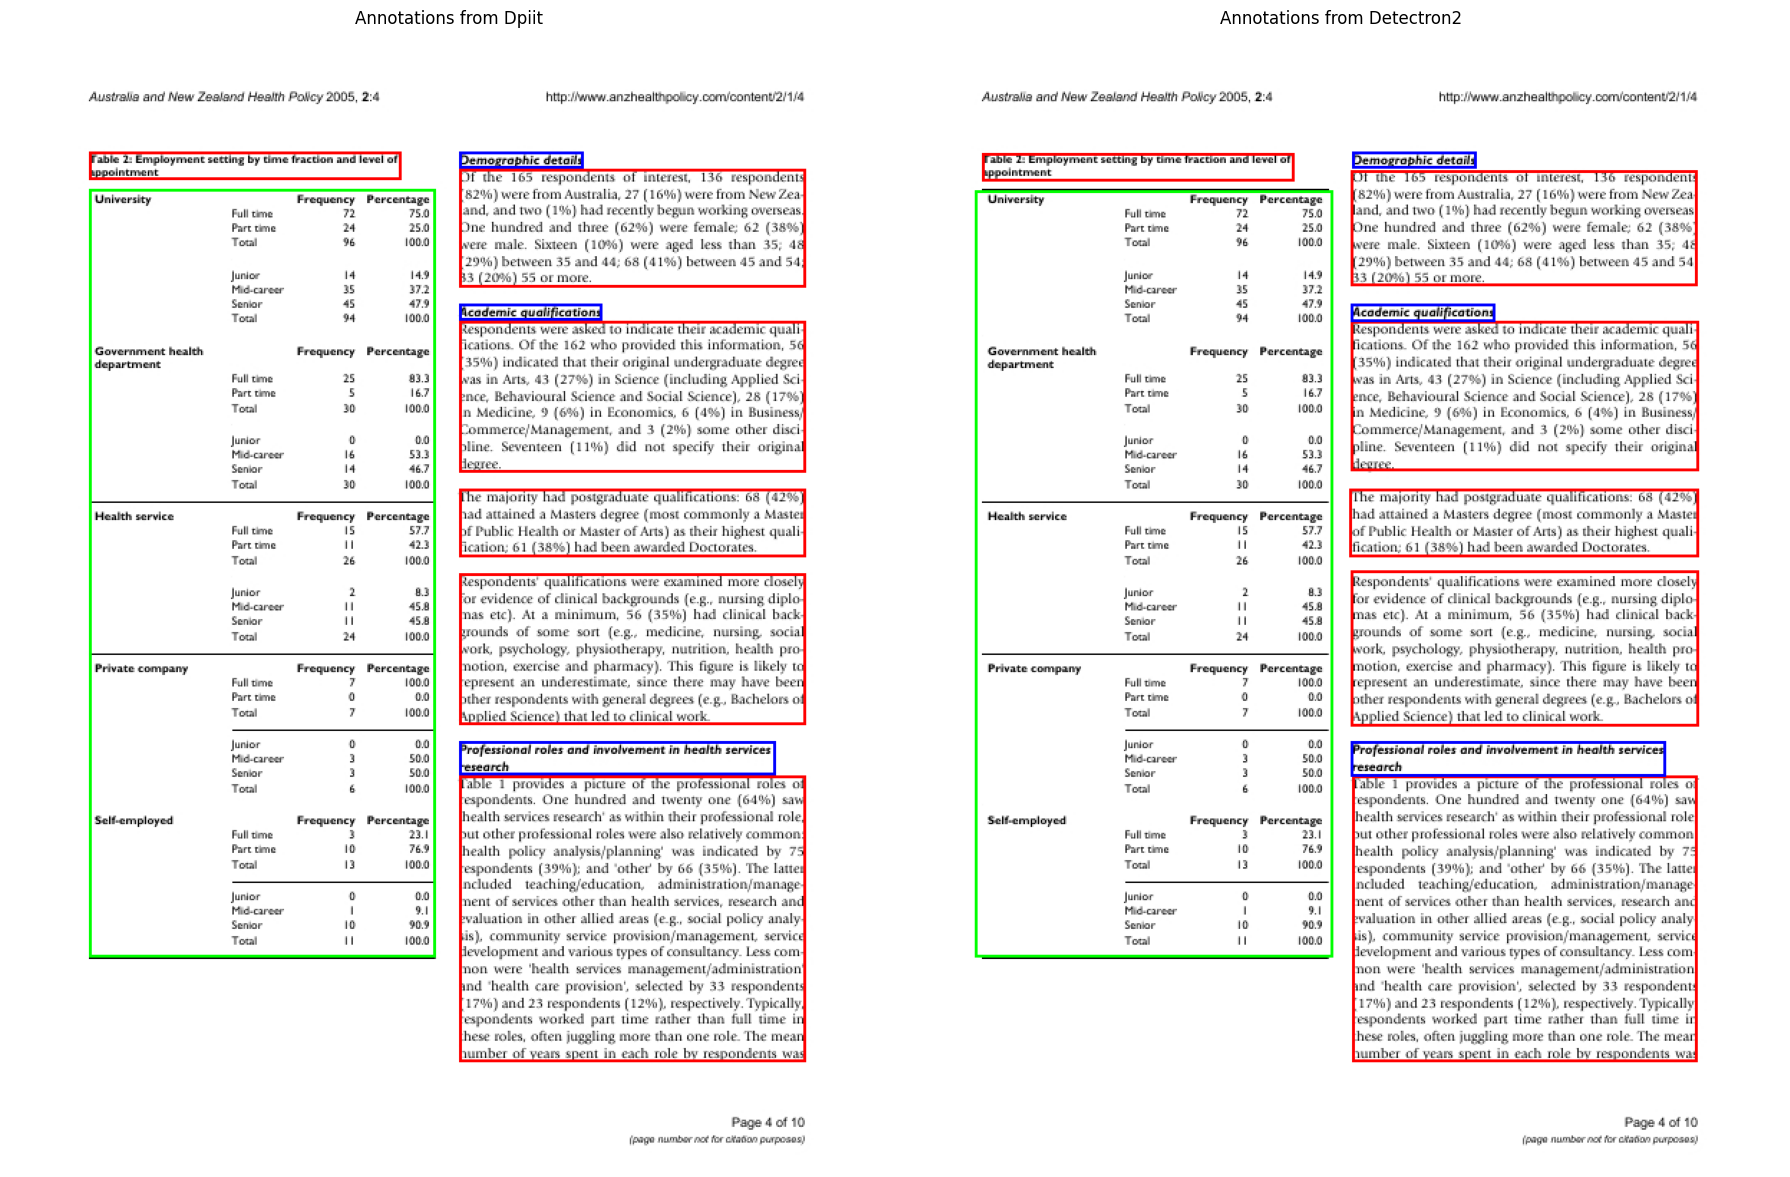

💾 Saved annotated images to /kaggle/working/


In [4]:
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
str=41
# --- CONFIGURE YOUR PATHS ---
# 👇 EDIT THESE THREE LINES ONLY 👇
IMAGE_FILE = f'/kaggle/input/traindata/train/doc_000{str}.png'
JSON_FILE_1 = f'/kaggle/input/trainjsongiven/trainjsonDPIIT/doc_000{str}.json'
JSON_FILE_2 = f'/kaggle/input/trainjson-detectron2/doc_000{str}.json'

# --- CATEGORY COLORS ---
CATEGORY_COLORS = {
    1: 'red',
    2: 'blue'
}
DEFAULT_COLOR = 'lime'
BOX_WIDTH = 2

# --- FUNCTION TO DRAW BOXES ON A COPY OF THE IMAGE ---
def draw_boxes(image_path, json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        annotations = data.get('annotations', [])
    except FileNotFoundError:
        print(f"❌ JSON not found: {json_path}")
        return None
    except json.JSONDecodeError:
        print(f"❌ Invalid JSON format: {json_path}")
        return None

    try:
        image = Image.open(image_path).convert('RGB')
        draw = ImageDraw.Draw(image)
    except FileNotFoundError:
        print(f"❌ Image not found: {image_path}")
        return None

    for ann in annotations:
        try:
            bbox = ann['bbox']
            category_id = ann.get('category_id', -1)
            x_min, y_min, width, height = bbox
            x_max, y_max = x_min + width, y_min + height
            color = CATEGORY_COLORS.get(category_id, DEFAULT_COLOR)
            draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=BOX_WIDTH)
        except Exception as e:
            print(f"⚠️ Skipped invalid annotation {ann}: {e}")

    return image


# --- GENERATE BOTH ANNOTATED IMAGES ---
annotated_img1 = draw_boxes(IMAGE_FILE, JSON_FILE_1)
annotated_img2 = draw_boxes(IMAGE_FILE, JSON_FILE_2)

# --- DISPLAY SIDE BY SIDE ---
if annotated_img1 and annotated_img2:
    fig, axes = plt.subplots(1, 2, figsize=(18, 12))

    axes[0].imshow(annotated_img1)
    axes[0].set_title(f"Annotations from Dpiit")
    axes[0].axis('off')

    axes[1].imshow(annotated_img2)
    axes[1].set_title(f"Annotations from Detectron2")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Optional: save both results
    annotated_img1.save(f"/kaggle/working/annotated_1.png")
    annotated_img2.save(f"/kaggle/working/annotated_2.png")
    print("💾 Saved annotated images to /kaggle/working/")
else:
    print("⚠️ One or both images failed to generate.")


In [5]:
# Install torchmetrics in your Kaggle notebook
!pip install -q torchmetrics

In [7]:
import json
import os
import glob
import torch
from torchmetrics.detection import MeanAveragePrecision
from tqdm.notebook import tqdm # Use notebook version for Kaggle

# --- !!! USER: SET YOUR PATHS HERE !!! ---
# Directory containing the GROUND TRUTH JSON files
GT_JSON_DIR = '/kaggle/input/trainjsongiven/trainjsonDPIIT/'

# Directory containing the PREDICTION JSON files (generated by your Detectron2 script)
PRED_JSON_DIR = '/kaggle/input/trainjson-detectron2/' # Or '/kaggle/working/trainjson/' if generated in this session

# --- Configuration ---
# Only evaluate these category IDs
EVAL_CATEGORIES = {1, 2, 5} 
# --------------------


# --- FUNCTION TO LOAD AND FORMAT ANNOTATIONS ---
def load_annotations(json_path, is_prediction=False):
    """Loads annotations from a JSON file and formats them for torchmetrics."""
    boxes = []
    labels = []
    scores = [] # Only for predictions

    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        annotations = data.get('annotations', [])
    except FileNotFoundError:
        #print(f"File not found: {json_path}")
        return None # Return None if file missing
    except Exception as e:
        print(f"❌ Error loading {os.path.basename(json_path)}: {e}")
        return None # Return None on other errors

    for ann in annotations:
        try:
            category_id = ann.get('category_id')
            # --- Filter by required categories ---
            if category_id not in EVAL_CATEGORIES:
                continue # Skip categories we don't care about

            bbox = ann['bbox'] # Expected format: [x_min, y_min, width, height]

            # Convert bbox to [xmin, ymin, xmax, ymax]
            x_min, y_min, width, height = map(float, bbox)
            x_max, y_max = x_min + width, y_min + height

            # Basic validation
            if width <= 0 or height <= 0 or x_min >= x_max or y_min >= y_max:
                #print(f"⚠️ Skipped invalid bbox: {bbox} in {os.path.basename(json_path)}")
                continue

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(category_id)

            if is_prediction:
                # Assign default score of 1.0 since Detectron2 JSON might not have scores
                # If your generated JSON *does* have a score/confidence field, get it here:
                # score = ann.get('score', 1.0) # Example if key is 'score'
                scores.append(1.0)

        except Exception as e:
            print(f"⚠️ Error processing annotation {ann} in {os.path.basename(json_path)}: {e}")

    # Convert to Tensors
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64)

    formatted_data = {"boxes": boxes_tensor, "labels": labels_tensor}
    if is_prediction:
        scores_tensor = torch.tensor(scores, dtype=torch.float32) if scores else torch.empty((0,), dtype=torch.float32)
        formatted_data["scores"] = scores_tensor

    return [formatted_data] # Wrap in a list for torchmetrics

# --- Find corresponding JSON file pairs ---
gt_files = glob.glob(os.path.join(GT_JSON_DIR, "*.json"))
preds_list = []
target_list = []
processed_files = 0
skipped_files = 0

print(f"Found {len(gt_files)} ground truth JSON files in {GT_JSON_DIR}")
print(f"Looking for matching prediction JSONs in {PRED_JSON_DIR}")

for gt_path in tqdm(gt_files, desc="Loading annotation pairs"):
    base_filename = os.path.basename(gt_path)
    pred_path = os.path.join(PRED_JSON_DIR, base_filename)

    # Load both files
    target_data = load_annotations(gt_path, is_prediction=False)
    preds_data = load_annotations(pred_path, is_prediction=True)

    # Only add to lists if both files were loaded successfully
    if target_data and preds_data:
        preds_list.extend(preds_data) # Use extend as load_annotations returns a list
        target_list.extend(target_data)
        processed_files += 1
    else:
        #print(f"Skipping pair for {base_filename} due to loading errors.")
        skipped_files += 1


print(f"\nSuccessfully loaded {processed_files} pairs.")
if skipped_files > 0:
    print(f"Skipped {skipped_files} pairs due to missing files or loading errors.")

# --- Calculate mAP ---
if processed_files > 0:
    print("\nCalculating mAP...")
    # Initialize metric
    # We set class_metrics=True to potentially see per-class results later
    metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)

    # Update metric with all loaded pairs
    # Note: preds_list and target_list now contain formatted data for all images
    metric.update(preds_list, target_list)

    # Compute final scores
    results = metric.compute()

    print("\n--- Overall mAP Results ---")
    print(f"Evaluated on {processed_files} images.")
    print(f"mAP (IoU=0.50:0.95): {results['map']:.4f}")
    print(f"mAP (IoU=0.50):      {results['map_50']:.4f}") # This is the mAP50 score
    print(f"mAP (IoU=0.75):      {results['map_75']:.4f}")

    # --- Optional: Print Per-Class mAP50 ---
    print("\nPer-class mAP (IoU=0.50):")
    label_map_dict = { 1: "Text", 2: "Title", 5: "Figure" }
    try:
        map_per_class_50 = results['map_per_class_50'].tolist()
        classes = results['classes'].tolist() # The actual class IDs found
        class_ap_dict_50 = dict(zip(classes, map_per_class_50))

        # Iterate through the classes we intended to evaluate
        for class_id in sorted(list(EVAL_CATEGORIES)):
            ap_50 = class_ap_dict_50.get(class_id, -1.0) # Get AP50 if class was present
            label_name = label_map_dict.get(class_id, f"ID {class_id}")
            if ap_50 != -1.0:
                 print(f"  Class {class_id} ({label_name}): {ap_50:.4f}")
            else:
                 # Check if this class just wasn't present in GT for this subset
                 total_gt_for_class = sum(t['labels'].eq(class_id).sum().item() for t in target_list)
                 if total_gt_for_class == 0:
                      print(f"  Class {class_id} ({label_name}): N/A (No ground truth instances found in processed files)")
                 else: # Present in GT but got 0 AP (likely no correct predictions)
                      print(f"  Class {class_id} ({label_name}): 0.0000")

    except KeyError:
        print("Could not retrieve per-class mAP50 scores.")
    except Exception as e:
         print(f"Error printing per-class scores: {e}")


else:
    print("\n⚠️ Cannot calculate mAP. No valid annotation pairs were loaded.")

Found 4000 ground truth JSON files in /kaggle/input/trainjsongiven/trainjsonDPIIT/
Looking for matching prediction JSONs in /kaggle/input/trainjson-detectron2/


Loading annotation pairs:   0%|          | 0/4000 [00:00<?, ?it/s]


Successfully loaded 4000 pairs.

Calculating mAP...

--- Overall mAP Results ---
Evaluated on 4000 images.
mAP (IoU=0.50:0.95): 0.5217
mAP (IoU=0.50):      0.6440
mAP (IoU=0.75):      0.5838

Per-class mAP (IoU=0.50):
Could not retrieve per-class mAP50 scores.
